# QCoDeS example with SR830

In [1]:
# IMPORTS

%matplotlib notebook
import qcodes as qc
from time import sleep
from qcodes.instrument_drivers.stanford_research.SR830 import SR830

In [2]:
# CONNECT TO INSTRUMENT

sr = SR830('lockin', 'GPIB0::8::INSTR')

Connected to: Stanford_Research_Systems SR830 (serial:s/n48280, firmware:ver1.07) in 0.16s


## List of parameters

In [3]:
sr.print_readable_snapshot()

lockin:
	parameter       value
--------------------------------------------------------------------------------
IDN              :	{'vendor': 'Stanford_Research_Systems', 'firmware': 'ver1....
P                :	None (deg)
R                :	None (V)
R_offset         :	None 
X                :	None (V)
X_offset         :	None 
Y                :	None (V)
Y_offset         :	None 
amplitude        :	None (V)
aux_in1          :	None (V)
aux_in2          :	None (V)
aux_in3          :	None (V)
aux_in4          :	None (V)
aux_out1         :	None (V)
aux_out2         :	None (V)
aux_out3         :	None (V)
aux_out4         :	None (V)
buffer_SR        :	None (Hz)
buffer_acq_mode  :	None 
buffer_npts      :	None 
buffer_trig_mode :	None 
ch1_databuffer   :	None (V)
ch1_display      :	None 
ch1_ratio        :	None 
ch2_databuffer   :	None (V)
ch2_display      :	None 
ch2_ratio        :	None 
ext_trigger      :	None 
filter_slope     :	None (dB/oct)
frequency        :	None (Hz)
harmonic         :	

## Buffered Acquisition

The SR830 has two internal data buffers corresponding to the displays of channel 1 and channel 2.

Here we present a simple way to measure one of these buffers.

Each buffer can hold 16383 points. The buffers are filled simultaneously. The QCoDeS driver always polls the **entire** buffer, so make sure to reset (clear) the buffer of old data before starting and acquisition.

In [4]:
# Set up channel 1 
sr.ch1_display('X')
sr.ch1_ratio('none')

In [5]:
# Set up the buffer
sr.buffer_SR(512)  # Sample rate (Hz)

In [6]:
# Now measure for 1 second
sr.buffer_reset()
sr.buffer_start() # Start filling the buffers with 512 pts/s
sleep(1)
sr.buffer_pause()  # Stop filling buffers

In [9]:
# Then perform a measurement
sr.ch1_databuffer.prepare_buffer_readout()  # MANDATORY
meas = qc.Measure(sr.ch1_databuffer)
data = meas.run()

DataSet:
   location = 'data/2017-06-21/#013_{name}_13-27-30'
   <Type>   | <array_id>            | <array.name>   | <array.shape>
   Measured | lockin_ch1_databuffer | ch1_databuffer | (461,)
acquired at 2017-06-21 13:27:30


<IPython.core.display.Javascript object>


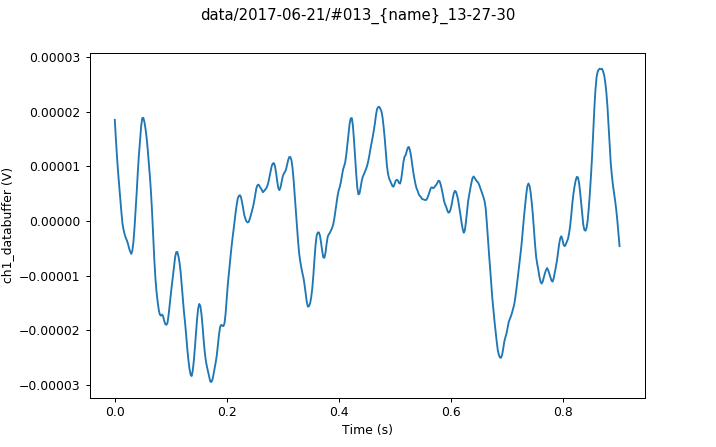

In [11]:
plot = qc.MatPlot()
plot.add(data.lockin_ch1_databuffer)

## Automatic sensitivity ranging

Why push the sensitivity up and down buttons yourself when QCoDeS can do it for you? Run something like this in your measurement loop to automatically adjust the sensitivity.

In [12]:
def autorange(srs, max_changes=1):
    def autorange_once():
        r = srs.R.get()
        sens = srs.sensitivity.get()
        if r > 0.9 * sens:
            return srs.increment_sensitivity()
        elif r < 0.1 * sens:
            return srs.decrement_sensitivity()
        return False

    sets = 0
    while autorange_once() and sets < max_changes:
        sets += 1
        time.sleep(srs.time_constant.get())